### 获取预调好的ResNet50，Xception，InceptionV3特征向量

In [1]:
root_src = 'D:\Dogs vs. Cats'
import os
import shutil
import time
os.chdir(root_src)
import numpy as np
import h5py
import h5py
import numpy as np
from sklearn.utils import shuffle
np.random.seed(2017)

X_train = []
X_test = []

for filename in ["gap_ResNet50.h5", "gap_Xception.h5", "gap_InceptionV3.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_test.append(np.array(h['test']))
        y_train = np.array(h['label'])

X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)

X_train, y_train = shuffle(X_train, y_train)

### 打印当前X_train,X_test张量的大小

In [2]:
print(X_train.shape,X_test.shape)

(25000, 6144) (12500, 6144)


### 设置预训练后的网络结构（参考https://github.com/ypwhs/dogs_vs_cats/blob/master/gap_train.ipynb）

In [3]:
from keras.models import *
from keras.layers import *

np.random.seed(2017)

input_tensor = Input(X_train.shape[1:])
# 可能会有部分特征一致或者类似，所以dropout一些特征，另一方面也可以防止过拟合
x = Dropout(0.25)(input_tensor)
x = Dense(1, activation='sigmoid')(x)#直接设置全连接
model = Model(input_tensor, x)

model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Using TensorFlow backend.


### 使用[graphviz](https://nbviewer.jupyter.org/github/xflr6/graphviz/blob/master/examples/notebook.ipynb)进行模型可视化

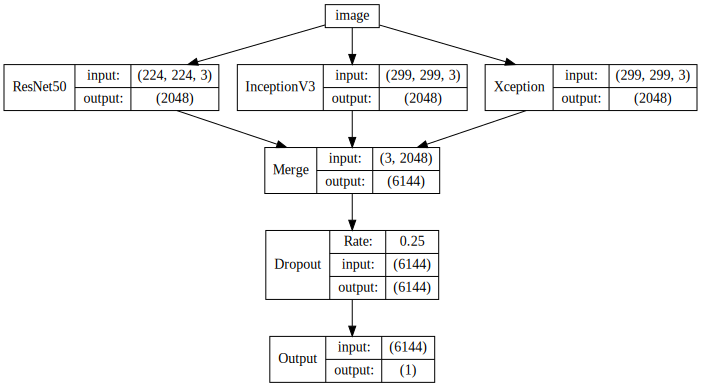

In [4]:
from graphviz import Digraph
g = Digraph('g',node_attr={'shape': 'record', 'height': '.1'})

g.node('node0','image')
g.node('node1','ResNet50|{input:|output:}|{(224, 224, 3)|(2048)} ')
g.node('node2','InceptionV3|{input:|output:}|{(299, 299, 3)|(2048)}')
g.node('node3','Xception|{input:|output:}|{(299, 299, 3)|(2048)}')
g.node('node4','Merge|{input:|output:}|{(3, 2048)|(6144)}')
g.node('node5','Dropout|{Rate:|input:|output:}|{0.25|(6144)|(6144)}')
g.node('node6','Output|{input:|output:}|{(6144)|(1)}')

g.edge('node0','node1')
g.edge('node0','node2')
g.edge('node0','node3')
g.edge('node1','node4')
g.edge('node2','node4')
g.edge('node3','node4')
g.edge('node4','node5')
g.edge('node5','node6')
g

### 设立停止条件

In [5]:
from keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')

### 训练模型

In [6]:
model.fit(X_train, y_train, batch_size=128, epochs=10, validation_split=0.2,callbacks=[earlystopping])

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 7s - loss: 0.1056 - acc: 0.9748 - val_loss: 0.0334 - val_acc: 0.9916
Epoch 2/10
20000/20000 [==============================] - 4s - loss: 0.0289 - acc: 0.9920 - val_loss: 0.0187 - val_acc: 0.9938
Epoch 3/10
20000/20000 [==============================] - 4s - loss: 0.0208 - acc: 0.9940 - val_loss: 0.0154 - val_acc: 0.9950
Epoch 4/10
20000/20000 [==============================] - 4s - loss: 0.0178 - acc: 0.9942 - val_loss: 0.0131 - val_acc: 0.9956
Epoch 5/10
20000/20000 [==============================] - 4s - loss: 0.0162 - acc: 0.9949 - val_loss: 0.0130 - val_acc: 0.9950
Epoch 6/10
20000/20000 [==============================] - 4s - loss: 0.0140 - acc: 0.9960 - val_loss: 0.0120 - val_acc: 0.9958
Epoch 7/10
20000/20000 [==============================] - 4s - loss: 0.0140 - acc: 0.9956 - val_loss: 0.0112 - val_acc: 0.9960
Epoch 8/10
20000/20000 [==============================] - 4s -

### 生成预测的csv文件（参考https://github.com/ypwhs/dogs_vs_cats/blob/master/gap_train.ipynb）

In [7]:
y_pred = model.predict(X_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

import pandas as pd
from keras.preprocessing.image import *

df = pd.read_csv("sample_submission.csv")

gen = ImageDataGenerator()
test_generator = gen.flow_from_directory("test", (224, 224), shuffle=False, 
                                         batch_size=16, class_mode=None)
# 获取文件的序号并减1，然后设置到新预测的csv文件的序号
for i, fname in enumerate(test_generator.filenames):
    index = int((fname.split('\\')[1]).split('.')[0])
    df.set_value(index-1, 'label', y_pred[i])

df.to_csv('sample_submission1.csv', index=None)
df.head(10)

12448/12500 [============================>.] - ETA: 0sFound 12500 images belonging to 1 classes.


,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005
5,6,0.005
6,7,0.005
7,8,0.005
8,9,0.005
9,10,0.005
